**Brian Blaylock**
**November 21, 2018**  Happy Thanksgiving! 🦃

# Cartopy Tutorial

I am told Basemap should no longer be used. That's too bad, becuase it was intuitive and easy to learn and control. Cartopy is missing some things, like US boundaries and US counties built into it. I will, however, figure this out sooner or later.

Resources:
- [Cartopy Documentation](https://scitools.org.uk/cartopy/docs/latest/)
    - [Cartopy Advanced mapping](https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/advanced_plotting.html)
- [Tutorial by Nathan Wendt](https://github.com/nawendt/cartopy-tutorial)
- [MetPy Counties Lines](https://unidata.github.io/MetPy/latest/examples/plots/US_Counties.html#sphx-glr-examples-plots-us-counties-py)

`crs` submodule stands for the Coordinate Reference System and defines the Coordinate Reference Systems and the transformations between them.

> NOTE: you cannot use `pcolormesh` and `cartopy` together with `matplotlib 3.0.0`. Upgrade matplotlib to version `3.0.1` or higher.

### Issues I have run into
- Cannot label gridlines on a LambertConformal plot.  Only PlateCarree and Mercator plots are currently supported.
- Transforming an imshow image from one map projection to antoher is either extreamly slow or doesn't work at all.
- To add a colorbar, you must explicitly reference the object and the axis. For example `plt.colorbar(cs, ax=ax)` where cs is a ax.pcolormesh or ax.contour object and ax is the figure axes.
- Map extent for HRRR `pcolormesh` objects to not auto scale correctly.
- Can not easily add a background image from ArcGIS servers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy import feature
from metpy.plots import USCOUNTIES

from pyproj import Proj

In [2]:
# load some HRRR data
gust = np.load('./data/HRRR_F00_20181010-1400_GUST-surface.npy').item()

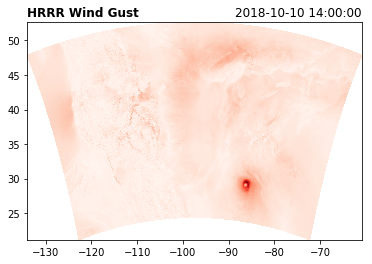

In [3]:
# Plot the raw data on a flat map
plt.pcolormesh(gust['lon'], gust['lat'], gust['value'], cmap='Reds')
plt.title('HRRR Wind Gust', fontweight='semibold', loc='left')
plt.title(gust['valid'], loc='right');

# HRRR Lambert Conformal

From HRRR [namelist.wps](https://rapidrefresh.noaa.gov/hrrr/HRRR/static/HRRRv3/conus/)
>dx = 3000,  
 dy = 3000,  
 map_proj =  'lambert',  
 ref_lat   = 38.5,  
 ref_lon   = -97.5,  
 truelat1  = 38.5,  
 truelat2  = 38.5,  
 stand_lon = -97.5,  

- central_latitude  : 38.5 (same as lat_0 in proj4) 
- central_longitude : -97.5 (same as lon_0)
- standard_parallels: (38.5, 38.5) (same as lat_1, lat_2)

> NOTE: use the **DictName to apply all the dictionary keys to the function arguments

In [4]:
lccProjParams_HRRR = { 'central_latitude'   : -38.5,        # same as lat_0 in proj4 string 
                       'central_longitude'  : -97.5,       # same as lon_0
                       'standard_parallels' : (38.5, 38.5), # same as (lat_1, lat_2)
                     }
HRRR_proj = ccrs.LambertConformal(**lccProjParams_HRRR)

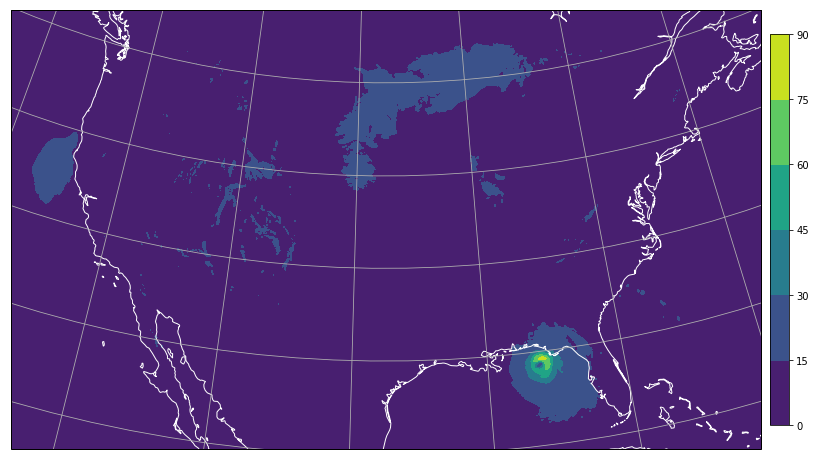

In [48]:
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = HRRR_proj)

# "source" projection
# Since we have lat/lon points for every data point, we use PlateCarree
#cf = ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
cf = ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

plt.colorbar(cf, ax=ax, shrink=.8, pad=.01)

ax.coastlines(resolution='50m', color='w')

#ax.set_extent([-130, gust['lon'][-1,-1], gust['lat'].max(), gust['lat'].min()], ccrs.PlateCarree())

## Draw the entire globe (do not auto scale)
#ax.set_global()
ax.gridlines()

In [6]:
gust['lon'][-1,-1]

-60.91719277183784

# GOES 16 Geostationary Projection

In [7]:
import xarray
from pyproj import Proj

In [8]:
C = xarray.open_dataset('./data/OR_ABI-L2-MCMIPC-M3_G16_s20182831437203_e20182831439576_c20182831440087.nc')

# True Color RGB

# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data


# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)


# Apply a gamma correction to the image
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)


# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

## Put together the RGB
RGB = np.dstack([R, G_true, B])

In [9]:
# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

print('Central Longitude', sat_lon)
print('Satellite_height', sat_h)
print('sweep_axis', sat_sweep)

Central Longitude -75.0
Satellite_height 35786023.0
sweep_axis x


In [10]:
geostationayProjParams_GOES16 = {'central_longitude' : sat_lon,
                                 'satellite_height' : sat_h,
                                 'sweep_axis' : sat_sweep
                                }

GOES16_proj = ccrs.Geostationary(**geostationayProjParams_GOES16)


In [11]:
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

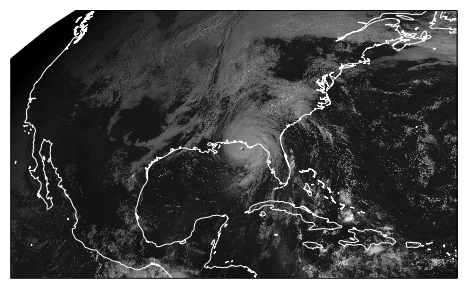

In [12]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = GOES16_proj)
ax.coastlines('50m', color='w')
ax.imshow(C['CMI_C01'], origin='upper', cmap='Greys_r', extent=(x.min(), x.max(), y.min(), y.max()))


# MetPy County Lines
NOTE: The highest resolution plots takes a long time, especially if you plot a large spatial area.

In [8]:
from metpy.plots import USCOUNTIES # Make sure metpy is updated to latest version.

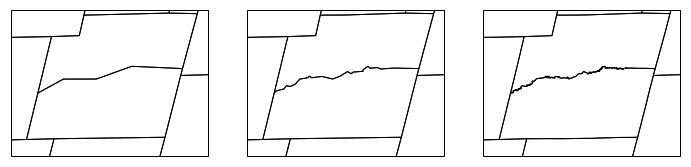

In [10]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(1, 3, 1, projection=GOES16_proj)
ax2 = fig.add_subplot(1, 3, 2, projection=GOES16_proj)
ax3 = fig.add_subplot(1, 3, 3, projection=GOES16_proj)

for scale, axis in zip(['20m', '5m', '500k'], [ax1, ax2, ax3]):
    axis.set_extent([270.25, 270.9, 38.15, 38.75], ccrs.Geodetic())
    axis.add_feature(USCOUNTIES.with_scale(scale), edgecolor='black')

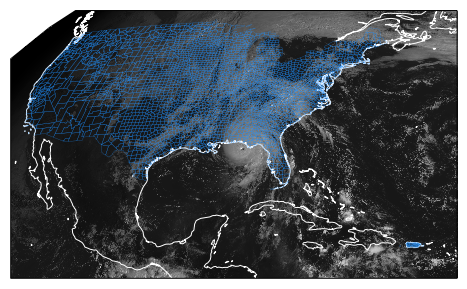

In [12]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = GOES16_proj)
ax.coastlines('50m', color='w')
ax.imshow(C['CMI_C01'], origin='upper', cmap='Greys_r', extent=(x.min(), x.max(), y.min(), y.max()))
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='dodgerblue', linewidth=.2)

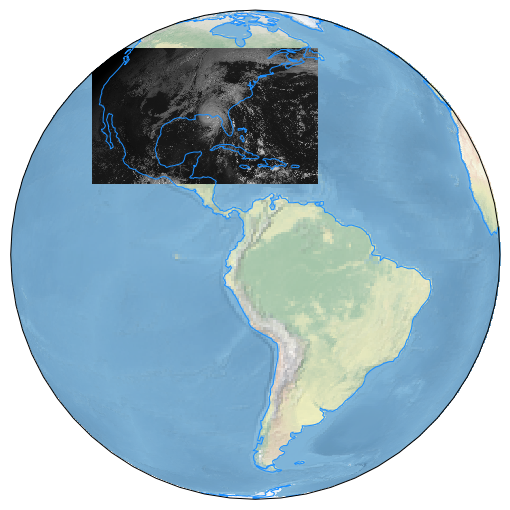

In [35]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = GOES16_proj)

ax.pcolormesh(lons, lats, C['CMI_C01'], cmap='Greys_r', transform=ccrs.PlateCarree())

ax.coastlines(resolution='110m', color='dodgerblue')
#ax.coastlines(resolution='50m', color='dodgerblue')
#ax.coastlines(resolution='10m', color='dodgerblue')

ax.set_global()

ax.stock_img()

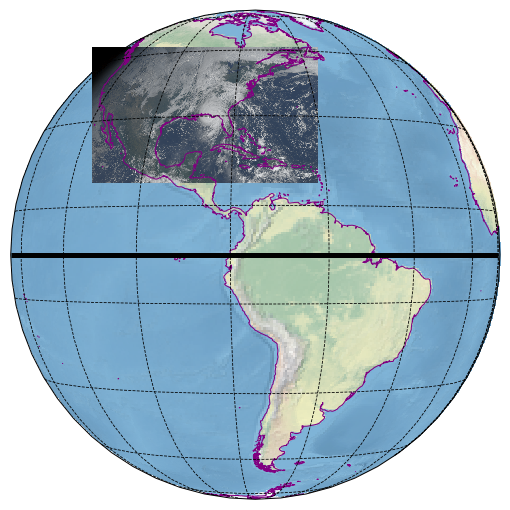

In [56]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = GOES16_proj)

ax.stock_img()

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=GOES16_proj)

ax.coastlines(resolution='50m', color='purple')

ax.set_global()
ax.gridlines(xlocs=range(0,361,20), ylocs=range(-90,90,20), color='k', linestyle='--')
ax.gridlines(ylocs=[0], color='k', linewidth=5)

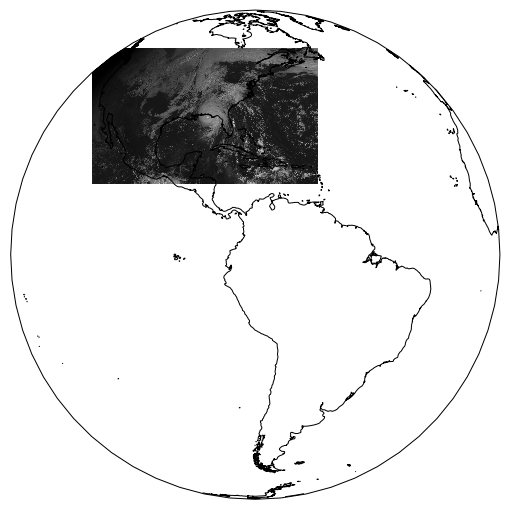

In [13]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = GOES16_proj)

ax.pcolormesh(lons, lats, C['CMI_C01'], cmap='Greys_r', transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')

ax.set_global()

In [23]:
hrrr_max_gust = np.nanmax(gust['value'])
index_max_gust = np.where(gust['value']==hrrr_max_gust)
lon_max_gust = gust['lon'][index_max_gust]
lat_max_gust = gust['lat'][index_max_gust]

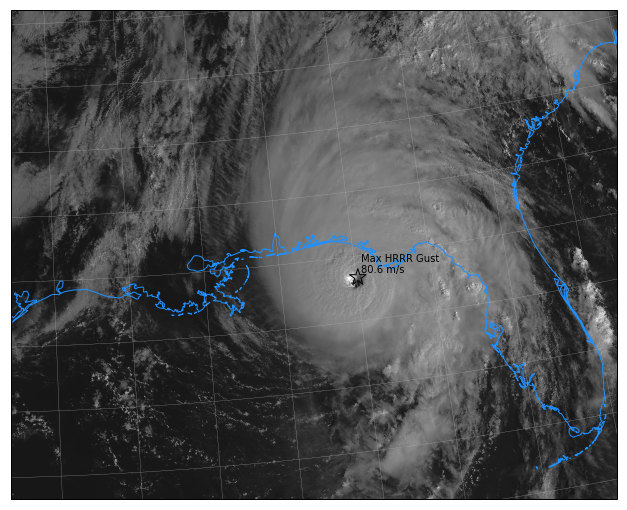

In [34]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = HRRR_proj)

# "Source" projection
ax.pcolormesh(lons, lats, C['CMI_C01'], cmap='Greys_r', transform=ccrs.PlateCarree())

ax.scatter(lon_max_gust, lat_max_gust,
           facecolor='none',
           edgecolor='k',
           marker='*',
           s=300,
           transform=ccrs.PlateCarree())

ax.text(lon_max_gust+.1, lat_max_gust+.1, 'Max HRRR Gust\n%.1f m/s' % hrrr_max_gust,
        transform=ccrs.PlateCarree())

ax.coastlines(resolution='10m', color='dodgerblue')

#ax.set_global()
ax.set_extent([-95, -80, 25, 35])
ax.gridlines(linewidth=.25)

Text(1,1,'GOES16 2018-10-10 14:00:00\nHRRR Gusts 2018-10-10 14:00:00')

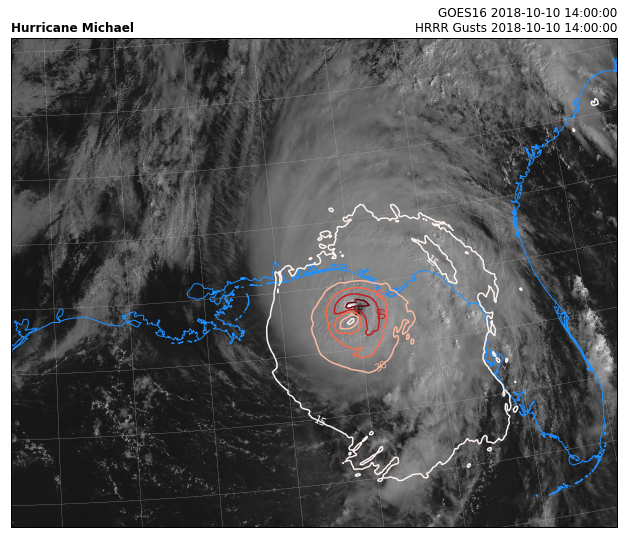

In [60]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = HRRR_proj)

# "Source" projection
ax.pcolormesh(lons, lats, C['CMI_C01'], cmap='Greys_r', transform=ccrs.PlateCarree())

cs = ax.contour(gust['lon'], gust['lat'], gust['value'],
                cmap='Reds', 
                transform=ccrs.PlateCarree())
plt.clabel(cs, inline_spacing=.001, fmt='%.f', inline=False)

ax.coastlines(resolution='10m', color='dodgerblue')

#ax.set_global()
ax.set_extent([-95, -80, 25, 35])
ax.gridlines(linewidth=.25)

plt.title('Hurricane Michael', loc='left', fontweight='bold')
plt.title('GOES16 %s\nHRRR Gusts %s' % (gust['valid'], gust['valid']), loc='right')

In [ ]:
# Transforming an image from one projection to another is extreamly slow or doesn't work for imshow.
'''
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = HRRR_proj)

# "Source" projection
ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=GOES16_proj)

ax.coastlines(resolution='110m', color='dodgerblue')

#ax.set_global()
#ax.set_extent([-95, -80, 25, 35])
ax.gridlines()
'''

---
But `imshow` transforms are either extreamly slow or do not work.
(i.e. transforming a RGB from it's geostationary projection to the HRRR projection)

We still have to use the color tuple method with pcolormesh.

In [15]:
# Create a color tuple for pcolormesh

# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the strange nature of pcolormesh.
rgb = RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to Stack Overflow. Not sure why.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


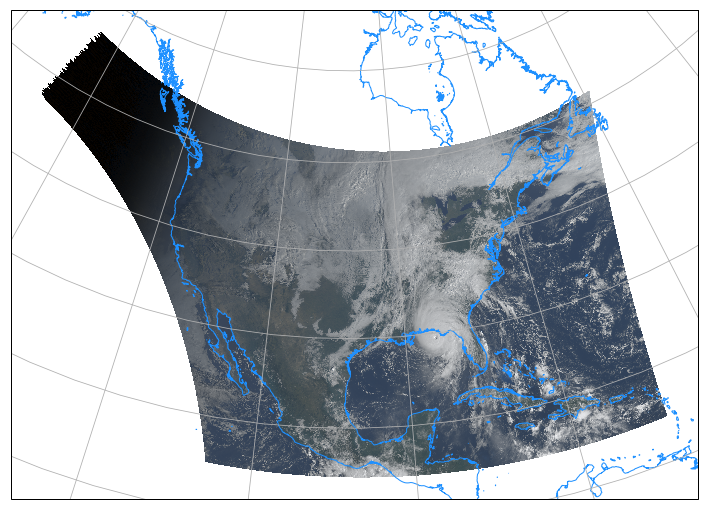

In [18]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = HRRR_proj)

# "Source" projection
newmap = ax.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, transform=ccrs.PlateCarree())
newmap.set_array(None)

ax.coastlines(resolution='10m', color='dodgerblue')

#ax.set_global()
#ax.set_extent([-95, -80, 25, 35])
ax.gridlines()

----

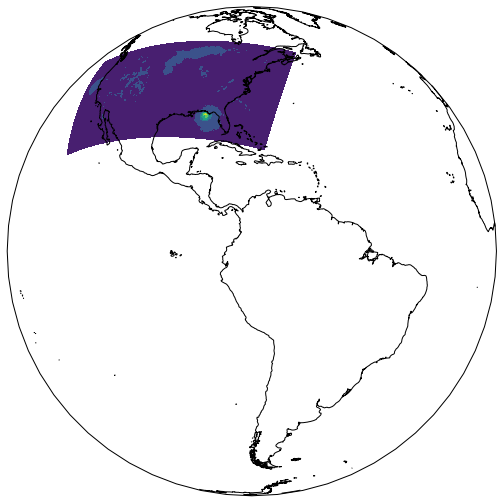

In [19]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = GOES16_proj)

# "source" projection
# Since we have lat/lon points for every data point, we use PlateCarree
#ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')

ax.set_global()